## Part 7: Map Statistics

In the final part of this tutorial, we use _mdx2_ with _pandas_ to calculate statistical properties of the diffuse map. _Pandas_ is a Python library commonly used in data science to manipulate tabular data. It will be used here without explanation; see [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) for an introduction.

First import the needed libraries and define convenience functions:

In [1]:
from mdx2.utils import loadobj, saveobj
from mdx2.data import HKLTable
import pandas as pd
import numpy as np

Crystal = loadobj('geometry.nxs','crystal')

def hkl2s(h,k,l):
    """Compute the magnitude of s from Miller indices."""
    UB = Crystal.ub_matrix
    s = UB @ np.stack((h,k,l))
    return np.sqrt(np.sum(s*s,axis=0))

Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry


### Intensity vs. resolution

The following Python program calculates the mean and standard deviation of intensity in shells of constant resolution:

Reading hkl_table from merged.nxs
  importing as HKLTable from mdx2.data


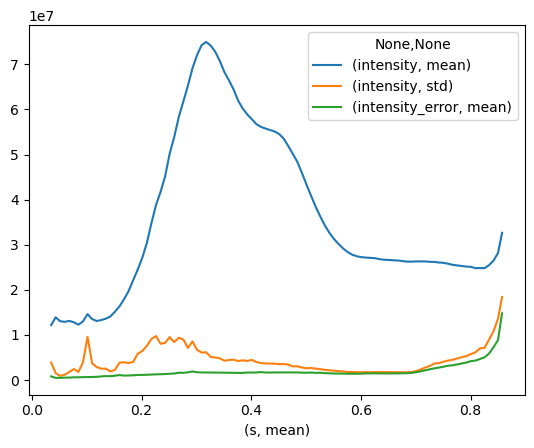

In [2]:
# load table as mdx2 object and convert to pandas dataframe
tab = loadobj('merged.nxs','hkl_table')
tab.s = hkl2s(tab.h,tab.k,tab.l)
df = tab.to_frame().set_index(['h','k','l']).sort_index()

# divide into 100 equal sized bins
s_bins = pd.cut(df['s'],100)

# compute statistics in each bin
df_isoavg = df.groupby(s_bins).agg({
    's':'mean',
    'intensity':['mean','std'],
    'intensity_error':'mean'})

# plot statistics vs. s
df_isoavg.set_index(('s','mean')).plot();

### Correlation of half-datasets

To quantify the precision of the final diffuse map, the dataset can be split into equivalent halves and the correlation coefficient computed between them in shells of constant resolution. _Mdx-lib_ has built-in tools for splitting unmerged datasets randomly with similar statistical weight. This method is not available in _mdx2_ version 0.3.1. Here, we use _pandas_ to split the data by assigning asymmetric units to each half (splitting on the `op` column of the data table). The following python script reads the unmerged data from `corrected.nxs` and saves two files: `split_1.nxs` and `split_2.nxs`.
 

In [3]:
tab = loadobj('corrected.nxs','hkl_table')
df = tab.to_frame()

# split into two halves based on the symmetry operator
grouped = df.groupby(pd.cut(df['op'],2))

# save as nexus files for merging with mdx2.merge
for grp,filename in zip(grouped,('split_1.nxs','split_2.nxs')):
    print('interval:',grp[0])
    _tmp = HKLTable.from_frame(grp[1])
    _tmp.ndiv = tab.ndiv # add back the grid subdivision info
    saveobj(_tmp,filename)

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
interval: (-0.023, 11.5]
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to split_1.nxs
interval: (11.5, 23.0]
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to split_2.nxs


Next, scale and merge each half dataset using _mdx2_ on the command line:

In [4]:
!mdx2.merge split_1.nxs --scale scales.nxs --outfile merged_1.nxs
!mdx2.merge split_2.nxs --scale scales.nxs --outfile merged_2.nxs

Reading hkl_table from split_1.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_1.nxs
done!
Reading hkl_table from split_2.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_2.nxs
done!


Finally, load the merged datasets as _pandas_ dataframes and compute correlation coefficients in shells of constant resolution:

Reading hkl_table from merged_1.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from merged_2.nxs
  importing as HKLTable from mdx2.data


<AxesSubplot: xlabel='s'>

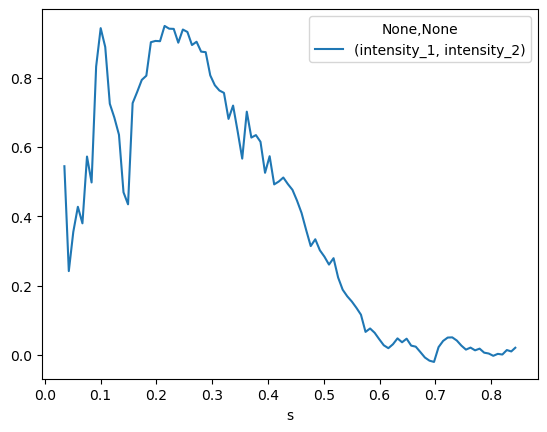

In [5]:
# load the tables and convert to pandas dataframe
t1 = loadobj('merged_1.nxs','hkl_table')
t2 = loadobj('merged_2.nxs','hkl_table')
t1.s = hkl2s(t1.h,t1.k,t1.l)
df1 = t1.to_frame().set_index(['h','k','l'])
df2 = t2.to_frame().set_index(['h','k','l'])

# merge the two tables
df12 = df1.merge(df2,on=('h','k','l'),suffixes=('_1','_2'))

# compute pearson correlation within resolution shells
s_bin = pd.cut(df12.s,100) # 100 bins
corr_binned = df12.groupby(s_bin)['intensity_1','intensity_2'].corr(method='pearson').unstack()
corr_binned['s'] = df12.groupby(s_bin)['s'].mean()

# plot the results
corr_binned.plot(x='s',y=('intensity_1','intensity_2'))